## 세상에 없는 얼굴 GAN, 오토인코더

### 적대적 신경망 실행하기

#### 실습 : DCGAN 모델 만들기

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 생성자 모델 생성
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [8]:
# 판별자 모델 생성
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [9]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 생성
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_2 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


1/1 [==============================] - 0s 99ms/step
epoch:0 d_loss:0.5442 g_loss:0.6105
1/1 [==============================] - 0s 57ms/step
epoch:1 d_loss:0.4544 g_loss:1.1748
1/1 [==============================] - 0s 56ms/step
epoch:2 d_loss:0.5108 g_loss:1.1265
1/1 [==============================] - 0s 54ms/step
epoch:3 d_loss:0.4721 g_loss:0.8645
1/1 [==============================] - 0s 92ms/step
epoch:4 d_loss:0.5509 g_loss:0.5847
1/1 [==============================] - 0s 62ms/step
epoch:5 d_loss:0.5988 g_loss:0.3762
1/1 [==============================] - 0s 56ms/step
epoch:6 d_loss:0.5881 g_loss:0.4335
1/1 [==============================] - 0s 55ms/step
epoch:7 d_loss:0.7052 g_loss:0.4516
1/1 [==============================] - 0s 59ms/step
epoch:8 d_loss:0.7507 g_loss:0.6218
1/1 [==============================] - 0s 62ms/step
epoch:9 d_loss:0.6203 g_loss:0.6098
1/1 [==============================] - 0s 146ms/step
epoch:10 d_loss:0.6152 g_loss:0.8229
1/1 [=========================

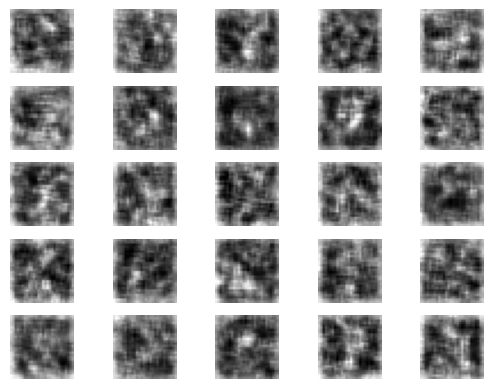

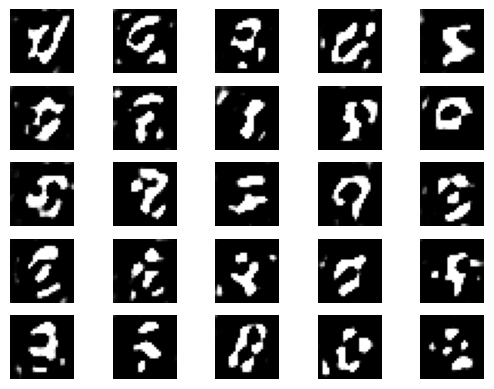

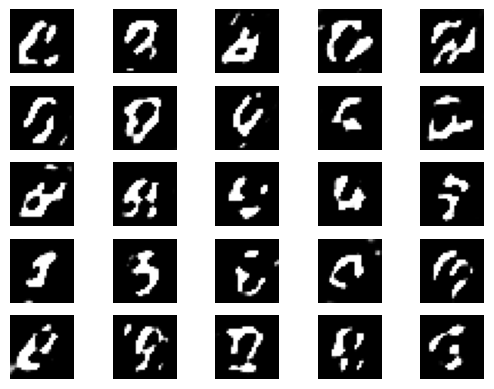

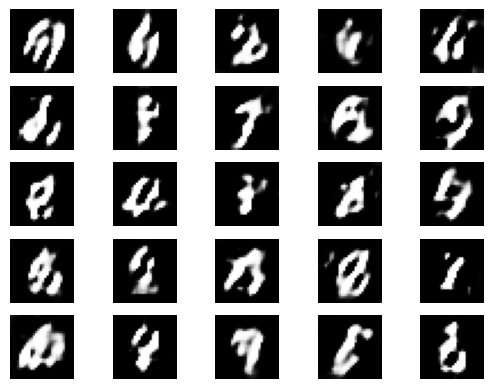

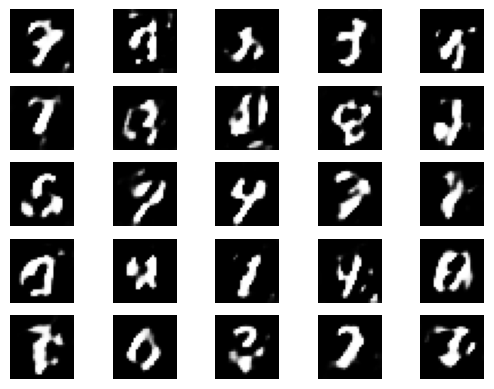

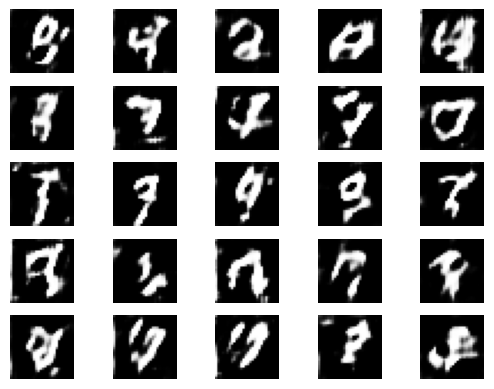

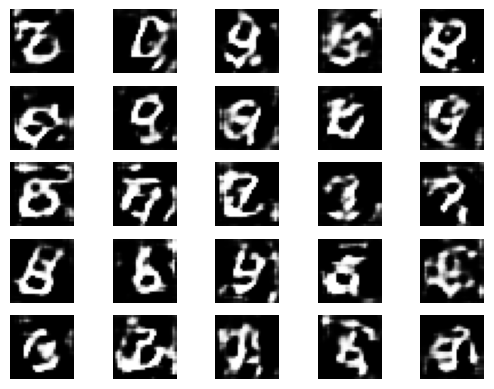

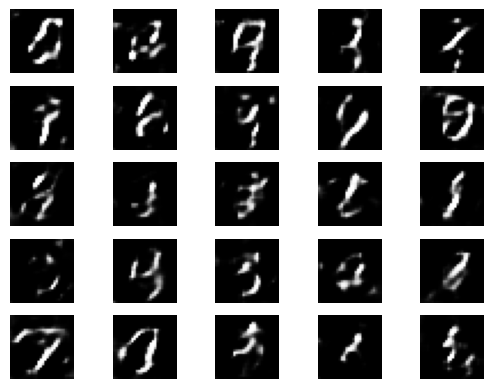

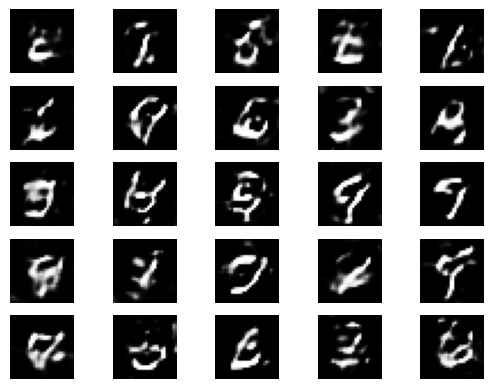

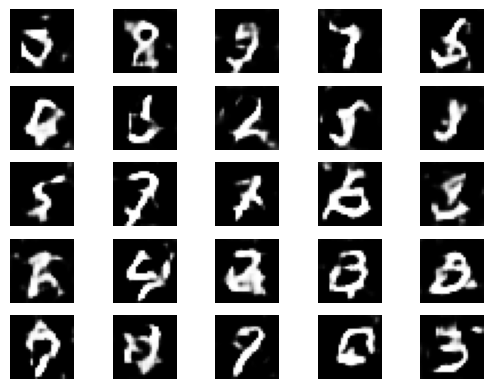

In [17]:
# 신경망을 실행시키는 함수 생성
def gan_train(epoch, batch_size, saving_interval):
  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data() # 앞서 불러온 적 있는 MNIST 다시 이용
  # 단 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러옴
  X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')
  X_train = (X_train - 127.5) / 127.5 # 픽셀 값을 0에서 255 사이의 값
  # 이전에 255로 나누어 줄 때는 이를 0~1 사이의 값으로 바꾸었던 것이지만
  # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로써 -1 에서 1 사이의 값으로 바뀌게 됨.
  # X_train.shape, y_train.shape, X_test.shape, y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    img = X_train[idx]
    d_loss_real = discriminator.train_on_batch(img, true)

    # 가상 이미지를 판별자에 입력하는 부분
    noise = np.random.normal(0,1, (batch_size,100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    g_loss = gan.train_on_batch(noise, true)

    # 판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    # 이부분은 중간 과정을 이미지로 저장해 주는 부분.
    # 만들어진 이미지는 gan_images 폴더에 저장됨

    if i % saving_interval == 0:
      # r, c = 5, 5
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)

      # Rescale image 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5,5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2000, 32, 200) # 200번 반복, 배치 사이즈 32, 200번마다 결과 저장


#### 오토인코더 실습

In [21]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

import matplotlib.pyplot as plt
import numpy as np

# MNNIST 데이터셋을 불러옴

(X_train, _), (X_test,_) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28,28,1).astype('float32') / 255

In [23]:
# 생성자 모델 생성
autoencoder = Sequential()

# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3,  padding='same', activation='sigmoid'))
autoencoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 55s 114ms/step - loss: 0.0782 - val_loss: 0.0769
Epoch 2/50
469/469 [==============================] - 52s 112ms/step - loss: 0.0778 - val_loss: 0.0768
Epoch 3/50
469/469 [==============================] - 53s 112ms/step - loss: 0.0778 - val_loss: 0.0771
Epoch 4/50
469/469 [==============================] - 52s 111ms/step - loss: 0.0777 - val_loss: 0.0768
Epoch 5/50
469/469 [==============================] - 53s 114ms/step - loss: 0.0777 - val_loss: 0.0772
Epoch 6/50
469/469 [==============================] - 52s 111ms/step - loss: 0.0777 - val_loss: 0.0768
Epoch 7/50
469/469 [==============================] - 53s 113ms/step - loss: 0.0777 - val_loss: 0.0767
Epoch 8/50
469/469 [==============================] - 53s 112ms/step - loss: 0.0776 - val_loss: 0.0766
Epoch 9/50
469/469 [==============================] - 53s 112ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 10/50
469/469 [==============================] - 53s 112ms/step - l

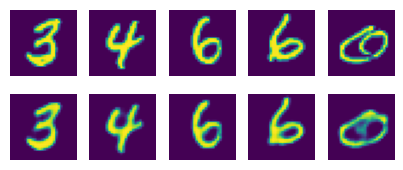

In [27]:
# 컴파일 및 학습
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train,X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test) )

# 학습 결과 츨력
random_test = np.random.randint(X_test.shape[0], size=5) # 테스트할 이미지를 랜덤하게 볼러옴
ae_imgs = autoencoder.predict((X_test)) # 앞서 만든 오토인코더 모델을 넣는다.

plt.figure(figsize=(7,2)) # 출력할 이미지 크기 지정

for i, image_idx in enumerate(random_test): # 랜덤하게 뽑은 이미지를 차례로 나열
  ax= plt.subplot(2,7,i+1)
  plt.imshow(X_test[image_idx].reshape(28,28))
  ax.axis('off')
  ax = plt.subplot(2,7,7+i+1)
  plt.imshow(ae_imgs[image_idx].reshape(28,28))
  ax.axis('off')

plt.show()
